## Load packages

In [15]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-darkgrid')

C:\Users\Victo\AppData\Local\Temp\ipykernel_6880\3818186681.py:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


### Load dataset

In [16]:
df = pd.read_csv('data_cleaned.csv')

# indicate dummy features
df.iloc[:,19:99] = df.iloc[:,19:99].astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4947 entries, 0 to 4946
Data columns (total 99 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   income_am               4947 non-null   float64 
 1   profit_last_am          4947 non-null   float64 
 2   profit_am               4947 non-null   float64 
 3   damage_am               4947 non-null   float64 
 4   crd_lim_rec             4947 non-null   float64 
 5   cab_requests            4947 non-null   int64   
 6   bar_no                  4947 non-null   int64   
 7   neighbor_income         4947 non-null   float64 
 8   age                     4947 non-null   int64   
 9   tenure_mts              4947 non-null   int64   
 10  tenure_yrs              4947 non-null   int64   
 11  claims_am               4947 non-null   float64 
 12  nights_booked           4947 non-null   int64   
 13  shop_am                 4947 non-null   int64   
 14  outcome_profit          

In [17]:
df = df.drop(['outcome_damage_inc', 'outcome_damage_amount'], axis=1)

relocate outcome_profit to the last column

In [18]:
# Get the column name you want to move to the last column
feature_name = 'outcome_profit'

# Get a list of column names, excluding the feature to move
other_columns = [col for col in df.columns if col != feature_name]

# Reorder the columns so the feature is at the end
new_columns = other_columns + [feature_name]
df = df[new_columns]

## Train test split and standardisation

### Shuffle

In [19]:
from random import Random
df_shuffle = df.sample(frac=1, random_state=123)

### Train/test-split

In [20]:
# Import the function
from sklearn.model_selection import train_test_split

# Split of feaures and outcomes
X = df_shuffle.drop(['outcome_profit'],1)
y = df_shuffle['outcome_profit']


# train/split in training and test set
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)
# train/split in training and validation
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=4321)

C:\Users\Victo\AppData\Local\Temp\ipykernel_6880\440424924.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X = df_shuffle.drop(['outcome_profit'],1)


### Standardise

In [21]:

from sklearn.preprocessing import StandardScaler

num_feat = X_train.select_dtypes(include=['int64', 'float64']).columns

scaler = StandardScaler()

scaler.fit(X_train[num_feat])

X_train_stand = X_train.copy()
X_trainval_stand = X_train_val.copy()
X_val_stand = X_val.copy()
X_test_stand = X_test.copy()


X_train_stand[num_feat] = scaler.fit_transform(X_train_stand[num_feat])

X_val_stand[num_feat] = scaler.transform(X_val_stand[num_feat])
X_trainval_stand[num_feat] = scaler.transform(X_trainval_stand[num_feat])
X_test_stand[num_feat] = scaler.transform(X_test_stand[num_feat])

# Polynomial Regression

In [22]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=1)
X_train_poly = poly.fit_transform(X_train_stand)
X_val_poly = poly.transform(X_val_stand)
X_train_poly.shape

(3165, 97)

In [23]:
from sklearn import linear_model

linreg_lasso1 = linear_model.Lasso()
linreg_lasso1.fit(X_train_poly, y_train)
print('R2: %.3f' % linreg_lasso1.score(X_train_poly, y_train))
print('R2: %.3f' % linreg_lasso1.score(X_val_poly, y_val))

R2: 0.365
R2: 0.355


crossvalidation

In [24]:
# Using cross validation to find the best alpha

from sklearn.model_selection import cross_val_score
from sklearn import linear_model

Alpha = np.logspace(-3,0)
print(Alpha)
cv_scores = []
sd_scores = []
# perform 5-fold cross validation on the  possible values for the radius (bandwidth)

for a in Alpha:
    lasso = linear_model.Lasso(a, max_iter=3000)
    scores = cross_val_score(lasso, X_train_poly, y_train, cv=5)
    cv_scores.append(scores.mean())
    sd_scores.append(np.sqrt(scores.var())/np.sqrt(5))
 
max_value = max(cv_scores)
max_index = cv_scores.index(max_value)

train = linear_model.Lasso(Alpha[max_index], max_iter=3000)
train.fit(X_train_poly,y_train)

c:\Users\Victo\.virtualenvs\SchoolProject-jfK-57_F\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.399e+09, tolerance: 4.361e+05
  model = cd_fast.enet_coordinate_descent(
c:\Users\Victo\.virtualenvs\SchoolProject-jfK-57_F\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.160e+09, tolerance: 4.107e+05
  model = cd_fast.enet_coordinate_descent(
c:\Users\Victo\.virtualenvs\SchoolProject-jfK-57_F\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the fe

Lasso(max_iter=3000)

The optimal alpha is 1.0
The training score of the optimal alpha is 0.3645055015782068
The validation score of the optimal alpha is 0.3039687874543312


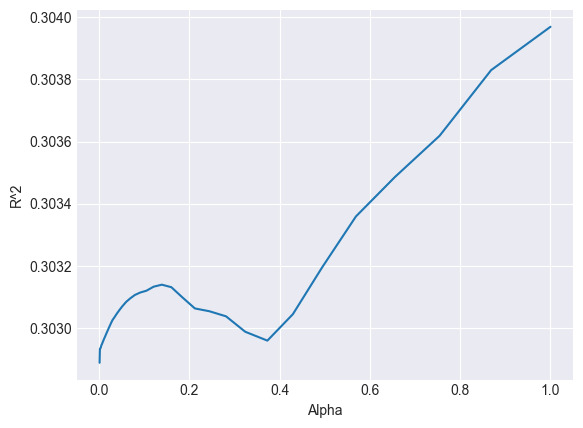

In [25]:
# plotting the best alpha

plt.plot(Alpha, cv_scores)
plt.xlabel('Alpha')
plt.ylabel('R^2')

print('The optimal alpha is', Alpha[max_index])
print('The training score of the optimal alpha is', train.score(X_train_poly,y_train))
print('The validation score of the optimal alpha is', max_value)

plt.show()

### Polynomial regression

In [26]:
# Calculate the best degree to use using the average score with cross-validation
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

avg_scores = [None] * 3
sd_scores = [None] * 3 	  # a degree > 3 will give R^2 in the (-) thousands
for i in np.arange(0,3):
    reg_poly = Pipeline([('stand', StandardScaler()),
                  ('poly', PolynomialFeatures(degree=i)),
                  ('linear', LinearRegression(fit_intercept=False))])
    
    scores = cross_val_score(reg_poly, X_train_poly, y_train, scoring = 'r2', cv=5)

    avg_scores[i] = scores.mean()
    sd_scores[i] = np.sqrt(scores.var())/np.sqrt(5)
    print("Order " + str(i) + ": avg R^2 = " + str(avg_scores[i]))

Order 0: avg R^2 = -0.002065768023697201
Order 1: avg R^2 = -1.896062605166532e+24
Order 2: avg R^2 = -319.59339909604694


niet goed!!!

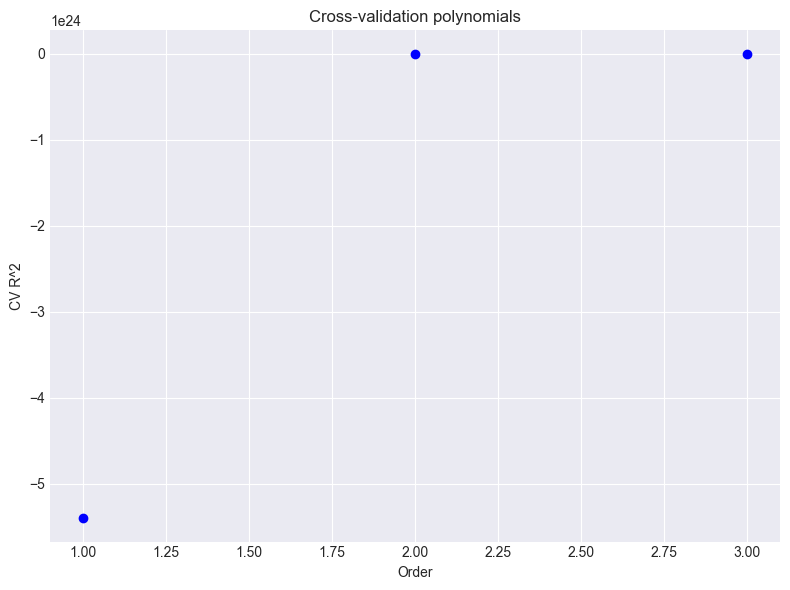

In [28]:
fig, ax = plt.subplots(figsize=(8, 4))
plt.scatter(np.arange(1,4), avg_scores, c='b', label='data')
plt.axis('tight')
plt.title("Cross-validation polynomials")
ax.set_xlabel("Order")
ax.set_ylabel("CV R^2")
plt.tight_layout()
plt.show()

In [27]:
# The best order with the maximum R^2?

max_value = max(avg_scores)
max_index = avg_scores.index(max_value)
print('The order with maximum R^2 is '+ str(max_index))

The order with maximum R^2 is 0


In [28]:
# Show the best score with the training set and testing set

reg_poly2 = Pipeline([('stand', StandardScaler()),
                  ('poly', PolynomialFeatures(degree=1)),
                  ('linear', LinearRegression(fit_intercept=False))])

reg_poly2.fit(X_train, y_train)
poly_train_res = reg_poly2.score(X_train, y_train)
poly_val_res = reg_poly2.score(X_val, y_val)

print(str(poly_train_res))
print(str(poly_val_res))

0.3693119762088858
0.34258641188108274


# K Nearest Neighbors

## Radius Neighbors Regression

cross validation

In [34]:
from sklearn.neighbors import RadiusNeighborsRegressor
from sklearn.model_selection import cross_val_score

Radius = np.linspace(21,28,30)   #waarom deze waarden ????????????????????????????????????
cv_scores = []
sd_scores = []

# perform 5-fold cross validation on the 11 possible values for the radius (bandwith)
for k in Radius:
    Rnn = RadiusNeighborsRegressor(radius=k)
    scores = cross_val_score(Rnn, X_train_stand, y_train,  cv=5)
    cv_scores.append(scores.mean())
    sd_scores.append(np.sqrt(scores.var())/np.sqrt(5))
    
    print("Radius " + str(k) + ": avg R^2 = " + str(scores.mean()))
    

Radius 21.0: avg R^2 = 0.04477099286507913
Radius 21.24137931034483: avg R^2 = 0.04211896955535137
Radius 21.482758620689655: avg R^2 = 0.040382380048115674
Radius 21.724137931034484: avg R^2 = 0.039325714291363154
Radius 21.96551724137931: avg R^2 = 0.03910697970069288
Radius 22.20689655172414: avg R^2 = 0.03869786604159773
Radius 22.448275862068964: avg R^2 = 0.03583291069513748
Radius 22.689655172413794: avg R^2 = 0.0312067426762332
Radius 22.93103448275862: avg R^2 = 0.029625187394140707
Radius 23.17241379310345: avg R^2 = 0.02867201904384975
Radius 23.413793103448278: avg R^2 = 0.02766170247049322
Radius 23.655172413793103: avg R^2 = 0.026573105698746425
Radius 23.896551724137932: avg R^2 = 0.024816323744311995
Radius 24.137931034482758: avg R^2 = 0.02284671966836771
Radius 24.379310344827587: avg R^2 = 0.021338904718339234
Radius 24.620689655172413: avg R^2 = 0.017456082026197483
Radius 24.862068965517242: avg R^2 = 0.014265616040216278
Radius 25.10344827586207: avg R^2 = 0.01037

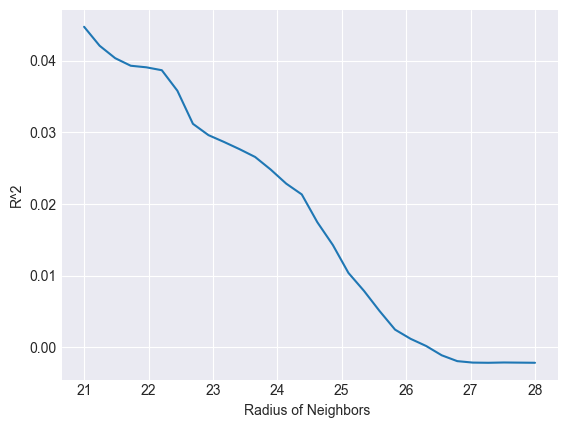

The best radius is 21.0


In [35]:
max_value = max(cv_scores)
max_index = cv_scores.index(max_value)

plt.plot(Radius, cv_scores)
plt.xlabel('Radius of Neighbors ')
plt.ylabel('R^2')

plt.show()
print('The best radius is', Radius[max_index])

In [36]:
# getting the best radius and validation score

max_value = max(cv_scores)
max_index = cv_scores.index(max_value)

print('The best radius is', Radius[max_index])

# retraining and testing

rnn_best = RadiusNeighborsRegressor(radius=Radius[max_index])
rnn_best.fit(X_train_stand, y_train)
print(rnn_best.score(X_train_stand, y_train))
print(max_value)

The best radius is 21.0
0.04261715442406677
0.04477099286507913


## K-nearest Neighbors

cross validation

In [39]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score

K = np.arange(1,100)    
cv_scores = []
sd_scores = []
# perform 5-fold cross validation on the  possible values for the radius (bandwith)
for k in K:
    knn = KNeighborsRegressor(n_neighbors= k)
    scores = cross_val_score(knn, X_train_stand, y_train,  cv=5)
    cv_scores.append(scores.mean())
    sd_scores.append(np.sqrt(scores.var())/np.sqrt(5))

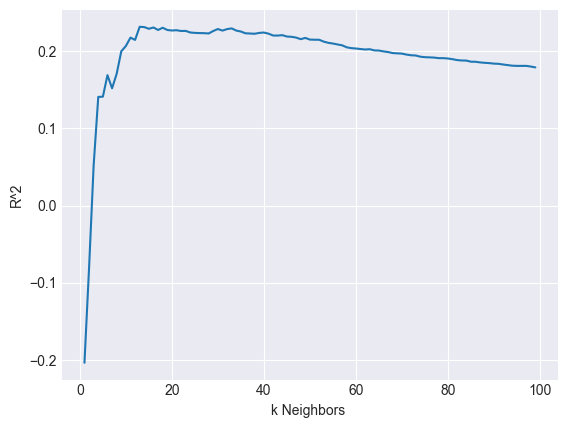

The best k is 13


In [40]:
max_value = max(cv_scores)
max_index = cv_scores.index(max_value)

plt.plot(K, cv_scores)
plt.xlabel('k Neighbors ')
plt.ylabel('R^2')

plt.show()
print('The best k is', K[max_index])

In [41]:
knn = KNeighborsRegressor(n_neighbors=K[max_index])
knn.fit(X_train_stand, y_train)

knn_train_res = knn.score(X_train_stand, y_train)
knn_val_res = knn.score(X_val_stand, y_val)

print(str(knn_train_res))
print(str(knn_val_res))

0.35018587732410544
0.34309651531533236


# Tree based

## Decision trees

cross validation

In [45]:
from sklearn.tree import DecisionTreeRegressor  
from sklearn.model_selection import cross_val_score

depth = np.arange(1,50)    # This will give an array of numbers between 1 and 10
cv_scores = []
sd_scores = []

# perform 5-fold cross validation on the  possible values for the radius (bandwith)
for d in depth:
    dec_tree = DecisionTreeRegressor(random_state = 0, max_depth=d)  
    scores = cross_val_score(dec_tree, X_train_stand, y_train,  cv=5)
    cv_scores.append(scores.mean())
    sd_scores.append(np.sqrt(scores.var())/np.sqrt(5))

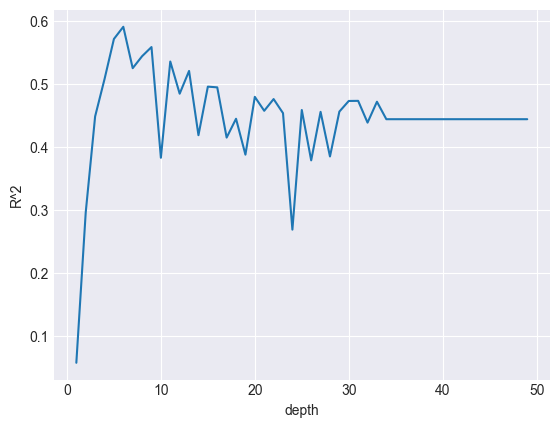

The best depth is 6
The best validation scorer is 0.5913854673247754


In [47]:
max_value = max(cv_scores)
max_index = cv_scores.index(max_value)

plt.plot(depth, cv_scores)
plt.xlabel('depth')
plt.ylabel('R^2')

plt.show()
print('The best depth is', depth[max_index])
print('The best validation scorer is', max_value)

In [54]:
dec_tree = DecisionTreeRegressor(random_state=0, max_depth=depth[max_index])
dec_tree.fit(X_train_stand, y_train) 

dt_train_res = dec_tree.score(X_train_stand, y_train)
dt_val_res = dec_tree.score(X_val_stand, y_val)

print(str(dt_train_res))
print(str(dt_val_res))

0.8360976775657876
0.6461391168823817


## Random Forest

### cross validation - random search

In [55]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

criterion =['squared_error','absolute_error']
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 500, num = 200)]
max_features = ['auto', 'sqrt', 'log2']
max_depth = [int(x) for x in np.linspace(1, 15, num = 15)]
min_samples_split = [int(x) for x in np.linspace(2, 15, num = 14)]
min_samples_leaf = [int(x) for x in np.linspace(1, 15, num = 15)]
max_leaf_nodes = [int(x) for x in np.linspace(10, 500, num = 490)]

# create the random grid to search for best hyperparameters
random_grid = {'criterion': criterion,
               'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'max_leaf_nodes': max_leaf_nodes}

# then do cross-validatoin
rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, 
                               cv = 3, verbose=2, random_state=42, n_jobs=-1)
# n_jobs=-1 to run as many models  parallel as possible
rf_random.fit(X_train_stand, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


c:\Users\Victo\.virtualenvs\SchoolProject-jfK-57_F\Lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'criterion': ['squared_error',
                                                      'absolute_error'],
                                        'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                      10, 11, 12, 13, 14, 15],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'max_leaf_nodes': [10, 11, 12, 13, 14,
                                                           15, 16, 17, 18, 19,
                                                           20, 21, 22, 23, 24,
                                                           25, 26, 27, 28, 29,
                                                           30, 31, 32, 33, 34,
                                                           35, 36, 37, 38, 39, ...],
                                        'min_samples_leaf': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9, 10, 11,
                                                             12, 13, 14, 15],
                                        'min_samples_split': [2, 3, 4, 5, 6, 7,
                                                              8, 9, 10, 11, 12,
                                                              13, 14, 15],
                                        'n_estimators': [100, 102, 104, 106,
                                                         108, 110, 112, 114,
                                                         116, 118, 120, 122,
                                                         124, 126, 128, 130,
                                                         132, 134, 136, 138,
                                                         140, 142, 144, 146,
                                                         148, 150, 152, 154,
                                                         156, 158, ...]},
                   random_state=42, verbose=2)

In [74]:
print(rf_random.best_score_)

rf_train_res = rf_random.score(X_train_stand, y_train)
rf_val_res = rf_random.score(X_val_stand, y_val)

print(rf_train_res) #training data
print(rf_val_res) #validation data

0.6908711210259053
0.8028886510921143
0.7956844095594733


In [57]:
rf_random.best_params_

{'n_estimators': 315,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_leaf_nodes': 485,
 'max_features': 'auto',
 'max_depth': 6,
 'criterion': 'absolute_error'}

In [58]:
out = pd.DataFrame(rf_random.cv_results_)
out.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_leaf_nodes,param_max_features,param_max_depth,param_criterion,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,281.991770,5.237231,0.146676,0.014887,385,7,14,90,auto,12,absolute_error,"{'n_estimators': 385, 'min_samples_split': 7, ...",0.511828,0.619283,0.624806,0.585306,0.052005,18
1,14.646230,6.444203,0.133010,0.064647,138,6,13,444,sqrt,6,absolute_error,"{'n_estimators': 138, 'min_samples_split': 6, ...",0.139160,0.242598,0.193841,0.191866,0.042251,82
2,1.909515,0.487860,0.144866,0.055935,128,12,4,148,log2,13,squared_error,"{'n_estimators': 128, 'min_samples_split': 12,...",0.314081,0.330600,0.359844,0.334841,0.018922,40
3,180.613904,2.926436,0.134420,0.060662,457,7,15,213,auto,2,absolute_error,"{'n_estimators': 457, 'min_samples_split': 7, ...",0.358688,0.419790,0.431816,0.403431,0.032017,30
4,30.604486,3.984266,0.124974,0.066411,274,12,8,191,sqrt,5,absolute_error,"{'n_estimators': 274, 'min_samples_split': 12,...",0.149404,0.239241,0.188944,0.192530,0.036763,81


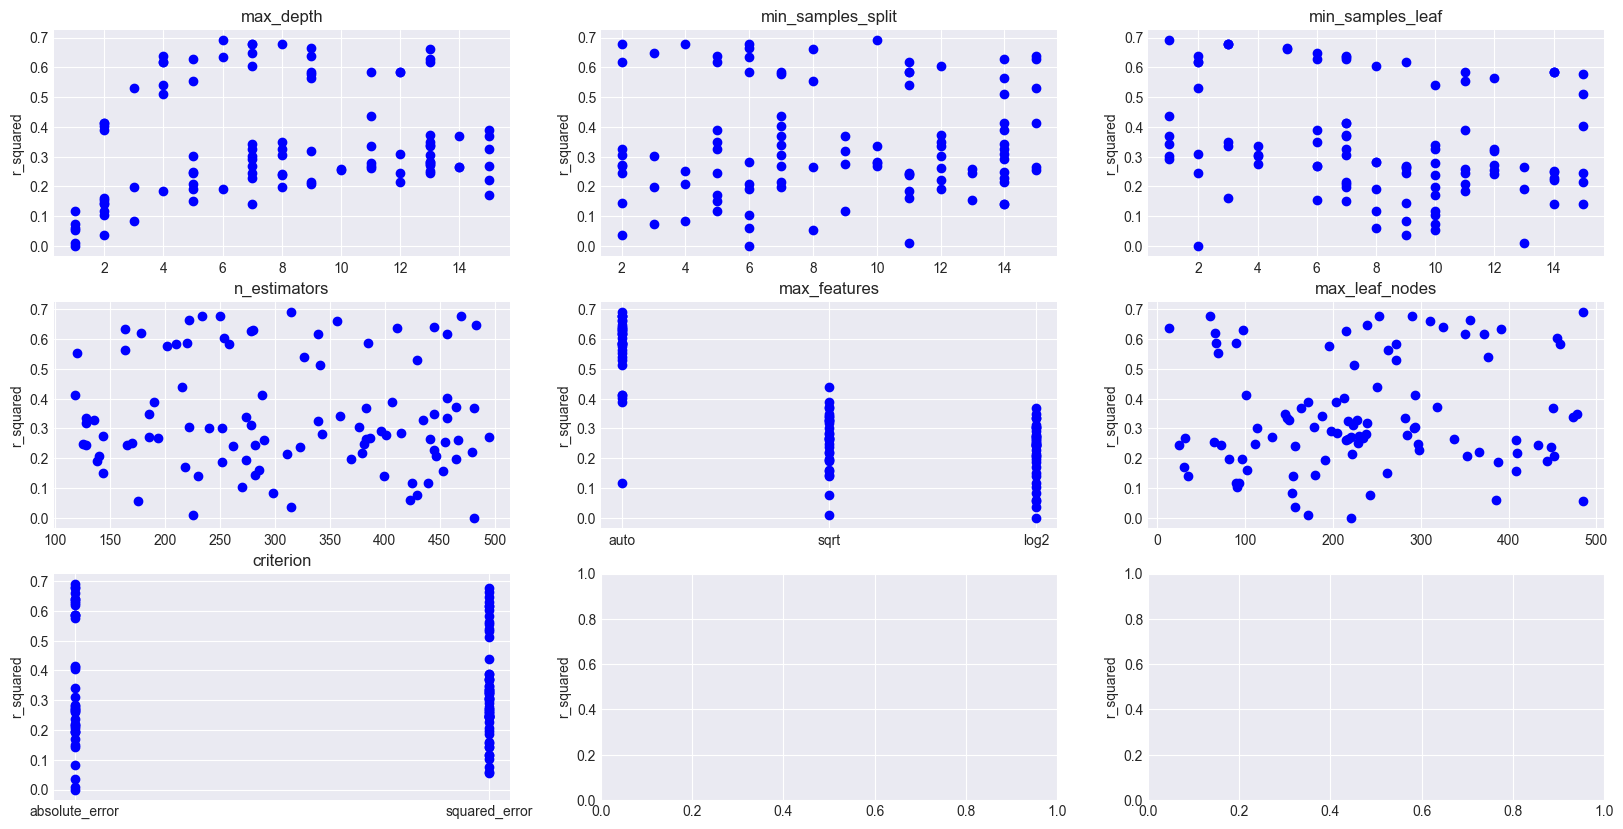

In [59]:
xlabel_names = ['param_max_depth','param_min_samples_split','param_min_samples_leaf','param_n_estimators',
                'param_max_features', 'param_max_leaf_nodes', 'param_criterion']

fig, axs = plt.subplots(3,3, figsize=(20,10))

axs[0,0].scatter(out['param_max_depth'], out['mean_test_score'], c='blue');
axs[0,0].set_title('max_depth')

axs[0,1].scatter(out['param_min_samples_split'], out['mean_test_score'], c='blue');
axs[0,1].set_title('min_samples_split')

axs[0,2].scatter(out['param_min_samples_leaf'], out['mean_test_score'], c='blue');
axs[0,2].set_title('min_samples_leaf')

axs[1,0].scatter(out['param_n_estimators'], out['mean_test_score'], c='blue');
axs[1,0].set_title('n_estimators')

axs[1,1].scatter(out['param_max_features'], out['mean_test_score'], c='blue');
axs[1,1].set_title('max_features')

axs[1,2].scatter(out['param_max_leaf_nodes'], out['mean_test_score'], c='blue');
axs[1,2].set_title('max_leaf_nodes')

axs[2,0].scatter(out['param_criterion'], out['mean_test_score'], c='blue');
axs[2,0].set_title('criterion')

for ax in axs.flat:
    ax.set(ylabel='r_squared')
    

### grid search

In [60]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

criterion =['absolute_error']
n_estimators = [315] #see best params
max_features = ['auto'] #see best params
max_depth = [6,8] #see plot
min_samples_split = [2,10] #see plot
min_samples_leaf = [1,3] #see plot
max_leaf_nodes = [485] #see best params


# create the random grid to search for best hyperparameters
grid = {'criterion': criterion,
               'n_estimators': n_estimators,
               'max_features': max_features,
                'max_leaf_nodes': max_leaf_nodes,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

# then do cross-validation
rf = RandomForestRegressor()
rf_grid = GridSearchCV(estimator=rf, param_grid=grid, cv=5,verbose=2, n_jobs=-1)

# n_jobs=-1 to run as many models  parallel as possible
rf_grid.fit(X_train_stand, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


c:\Users\Victo\.virtualenvs\SchoolProject-jfK-57_F\Lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'criterion': ['absolute_error'], 'max_depth': [6, 8],
                         'max_features': ['auto'], 'max_leaf_nodes': [485],
                         'min_samples_leaf': [1, 3],
                         'min_samples_split': [2, 10], 'n_estimators': [315]},
             verbose=2)

In [61]:
print(rf_grid.best_score_)

print(rf_grid.score(X_train_stand, y_train)) #training data
print(rf_grid.score(X_val_stand, y_val)) #validation data

0.6760063032345593
0.8408715829746142
0.7976376961246364


In [62]:
rf_grid.best_params_

{'criterion': 'absolute_error',
 'max_depth': 8,
 'max_features': 'auto',
 'max_leaf_nodes': 485,
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 315}

# whitening the black box (interpret results easier)

### feature importance

In [63]:
# Best params
params = rf_grid.best_params_
rf_gridBest = RandomForestRegressor(**params)
rf_gridBest.fit(X_train_stand, y_train)

c:\Users\Victo\.virtualenvs\SchoolProject-jfK-57_F\Lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


RandomForestRegressor(criterion='absolute_error', max_depth=8,
                      max_features='auto', max_leaf_nodes=485,
                      min_samples_split=10, n_estimators=315)

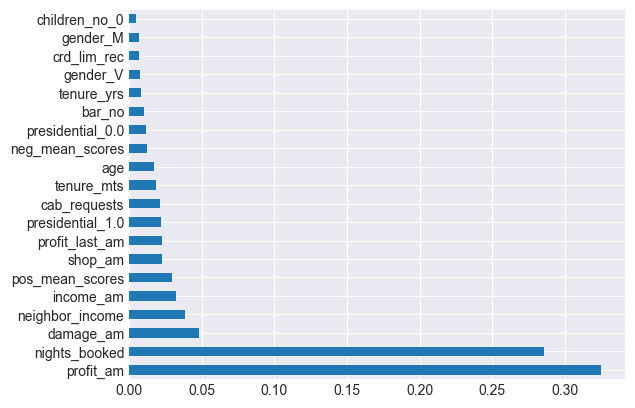

In [64]:
# Plot the 20 most important params

from matplotlib import pyplot as plt

plt.figure()

feat_importances = pd.Series(rf_gridBest.feature_importances_, index=X_train.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()

### Influence of each feature

In [65]:
# getting the prediction from the random forest
pred_train = rf_gridBest.predict(X_train_stand)

In [68]:
# Performing one univariate linear regression per feature on the predicted values.

from sklearn.linear_model import LinearRegression

X = pd.DataFrame(X_train_stand)
X.columns = X_train.columns
predictors =  X_train.columns
y = np.array((pred_train-pred_train.mean())/np.sqrt(pred_train.var())).reshape(-1, 1)

reg = LinearRegression().fit(X[[predictors[0]]], y)
beta = pd.Series(reg.coef_[0])
names = pd.Series(predictors[0])

for i in np.arange(1,(X.shape[1])):
    reg = LinearRegression().fit(X[[predictors[i]]], y)
    beta_help = pd.Series(reg.coef_[0])
    names_help = pd.Series(predictors[i])
    beta = pd.concat([beta,beta_help], axis=0)
    names = pd.concat([names,names_help], axis=0)

betas = pd.concat([names,beta],axis=1)
betas

,0,1
0,income_am,0.410054
0,profit_last_am,0.320379
0,profit_am,0.480652
0,damage_am,0.086835
0,crd_lim_rec,-0.094949
...,...,...
0,shop_use_Undefined,-0.088009
0,retired_0,-0.114591
0,retired_1,0.114591
0,gold_status_0,-0.893393


de lijst geeft hetzelfde weer zoals op de grafiek erboven. Zo kan je hier ook zien dat profit_am de belangrijkste feature is.

# Gradient boosting machine

In [69]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor

criterion =['squared_error','absolute_error']
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 500, num = 50)]
max_features = ['auto', 'sqrt', 'log2']
max_depth = [int(x) for x in np.linspace(1, 15, num = 15)]
min_samples_split = [int(x) for x in np.linspace(2, 15, num = 14)]
min_samples_leaf = [int(x) for x in np.linspace(1, 15, num = 15)]
max_leaf_nodes = [int(x) for x in np.linspace(10, 500, num = 50)]
loss = ['ls','lad','huber','quantile'] # see pwp 
learning_rate = [round(x,5) for x in np.linspace(0.1, 1, num = 10)] # see pwp default

# create the random grid to search for best hyperparameters
random_grid = {'criterion': criterion,
               'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'max_leaf_nodes': max_leaf_nodes,
               'loss': loss,
               'learning_rate': learning_rate}

# then do cross-validation
gbm = GradientBoostingRegressor()
gbm_random = RandomizedSearchCV(estimator = gbm, param_distributions = random_grid, n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1)

gbm_random.fit(X_train_stand, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


c:\Users\Victo\.virtualenvs\SchoolProject-jfK-57_F\Lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
237 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
76 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Victo\.virtualenvs\SchoolProject-jfK-57_F\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Victo\.virtualenvs\SchoolProject-jfK-57_F\Lib\site-packages\sklearn\ensemble\_gb.py", line 420, in fit
    self._validate_params()
  File "c:\Users\Victo\.virtualenvs\SchoolProject-jfK-57_F\Lib\site-packages\sklearn\base.py", line 581, in 

RandomizedSearchCV(cv=3, estimator=GradientBoostingRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'criterion': ['squared_error',
                                                      'absolute_error'],
                                        'learning_rate': [0.1, 0.2, 0.3, 0.4,
                                                          0.5, 0.6, 0.7, 0.8,
                                                          0.9, 1.0],
                                        'loss': ['ls', 'lad', 'huber',
                                                 'quantile'],
                                        'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                      10, 11, 12, 13, 14, 15],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'max_leaf_node...
                                                           150, 160, 170, 180,
                                                           190, 200, 210, 220,
                                                           230, 240, 250, 260,
                                                           270, 280, 290, 300, ...],
                                        'min_samples_leaf': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9, 10, 11,
                                                             12, 13, 14, 15],
                                        'min_samples_split': [2, 3, 4, 5, 6, 7,
                                                              8, 9, 10, 11, 12,
                                                              13, 14, 15],
                                        'n_estimators': [100, 108, 116, 124,
                                                         132, 140, 148, 157,
                                                         165, 173, 181, 189,
                                                         197, 206, 214, 222,
                                                         230, 238, 246, 255,
                                                         263, 271, 279, 287,
                                                         295, 304, 312, 320,
                                                         328, 336, ...]},
                   random_state=42, verbose=2)

In [76]:
print(gbm_random.best_score_)


print(gbm_random.score(X_train_stand, y_train)) #training data
print(gbm_random.score(X_val_stand, y_val)) #validation data

0.6714421544688026
0.8564272939574495
0.7598547889614231


In [71]:
gbm_random.best_params_

{'n_estimators': 189,
 'min_samples_split': 7,
 'min_samples_leaf': 15,
 'max_leaf_nodes': 260,
 'max_features': 'auto',
 'max_depth': 7,
 'loss': 'huber',
 'learning_rate': 0.1,
 'criterion': 'squared_error'}

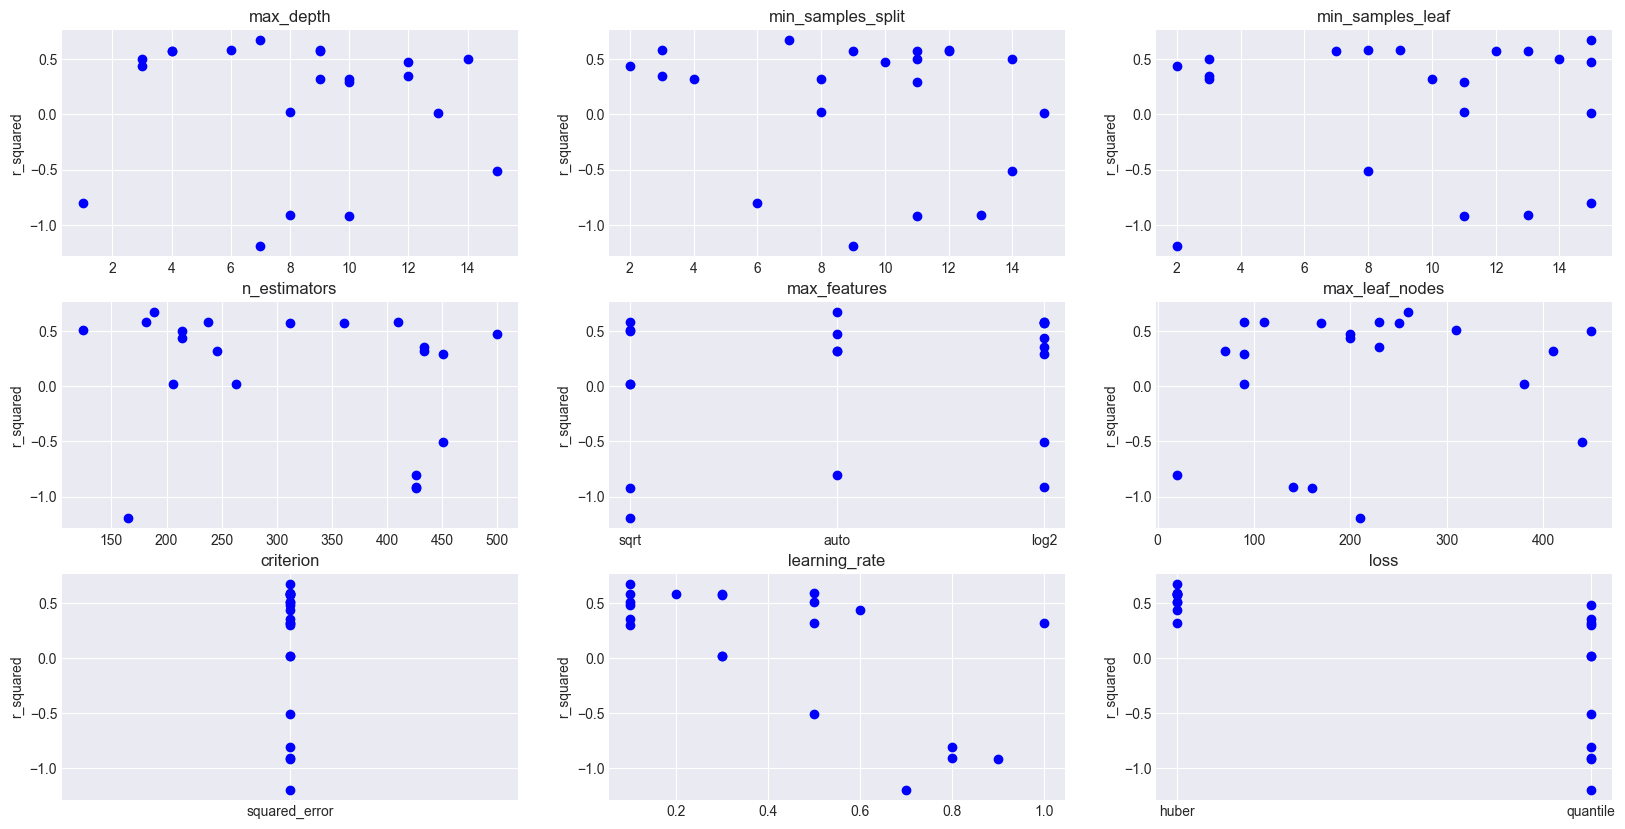

In [72]:
# plotting out the results of the hyperparameters

out = pd.DataFrame(gbm_random.cv_results_)

xlabel_names = ['param_max_depth','param_min_samples_split','param_min_samples_leaf','param_n_estimators',
                'param_max_features', 'param_max_leaf_nodes', 'param_criterion']

fig, axs = plt.subplots(3,3, figsize=(20,10))

axs[0,0].scatter(out['param_max_depth'], out['mean_test_score'], c='blue')
axs[0,0].set_title('max_depth')

axs[0,1].scatter(out['param_min_samples_split'], out['mean_test_score'], c='blue')
axs[0,1].set_title('min_samples_split')

axs[0,2].scatter(out['param_min_samples_leaf'], out['mean_test_score'], c='blue')
axs[0,2].set_title('min_samples_leaf')

axs[1,0].scatter(out['param_n_estimators'], out['mean_test_score'], c='blue')
axs[1,0].set_title('n_estimators')

axs[1,1].scatter(out['param_max_features'], out['mean_test_score'], c='blue')
axs[1,1].set_title('max_features')

axs[1,2].scatter(out['param_max_leaf_nodes'], out['mean_test_score'], c='blue')
axs[1,2].set_title('max_leaf_nodes')

axs[2,0].scatter(out['param_criterion'], out['mean_test_score'], c='blue')
axs[2,0].set_title('criterion')

axs[2,1].scatter(out['param_learning_rate'], out['mean_test_score'], c='blue')
axs[2,1].set_title('learning_rate')

axs[2,2].scatter(out['param_loss'], out['mean_test_score'], c='blue')
axs[2,2].set_title('loss')


for ax in axs.flat: ax.set(ylabel='r_squared')

lets tune the hyperparameters of the model a bit further with grid search

### grid search

In [73]:
from sklearn.model_selection import GridSearchCV

criterion =['squared_error']
n_estimators = [188,189]
max_features = ['auto']
max_depth = [7,9]
min_samples_split = [7,9]
min_samples_leaf = [8,15]
max_leaf_nodes = [260,245]
learning_rate = [0.1,0.2,0.25]
loss = ['squared_error']

# create the random grid to search for best hyperparameters
grid = {'criterion': criterion,
               'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
            'max_leaf_nodes': max_leaf_nodes,
               'learning_rate': learning_rate,
               'loss':loss}

# then do cross-validation
gbm = GradientBoostingRegressor()
gbm_grid = GridSearchCV(estimator = gbm, param_grid = grid, cv = 5, verbose=2,  n_jobs=-1)
# n_jobs=-1 to run as many models  parallel as possible
gbm_grid.fit(X_train_stand, y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


c:\Users\Victo\.virtualenvs\SchoolProject-jfK-57_F\Lib\site-packages\sklearn\tree\_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
c:\Users\Victo\.virtualenvs\SchoolProject-jfK-57_F\Lib\site-packages\sklearn\tree\_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
c:\Users\Victo\.virtualenvs\SchoolProject-jfK-57_F\Lib\site-packages\sklearn\tree\_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
c:\Users\Victo\.virtualenvs\SchoolProject-jfK-57_F\Lib\site-packages\sklearn\tree\_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed i

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'criterion': ['squared_error'],
                         'learning_rate': [0.1, 0.2, 0.25],
                         'loss': ['squared_error'], 'max_depth': [7, 9],
                         'max_features': ['auto'], 'max_leaf_nodes': [260, 245],
                         'min_samples_leaf': [8, 15],
                         'min_samples_split': [7, 9],
                         'n_estimators': [188, 189]},
             verbose=2)

In [77]:
print(gbm_grid.best_score_)

gb_train_res = gbm_grid.score(X_train_stand, y_train)
gb_val_res = gbm_grid.score(X_val_stand, y_val)



print(gb_train_res) #training data
print(gb_val_res) #validation data

0.7097577025915172
0.9593963735568608
0.7784935039694222


In [78]:
gbm_grid.best_params_

{'criterion': 'squared_error',
 'learning_rate': 0.1,
 'loss': 'squared_error',
 'max_depth': 7,
 'max_features': 'auto',
 'max_leaf_nodes': 245,
 'min_samples_leaf': 8,
 'min_samples_split': 9,
 'n_estimators': 189}

# Evaluation

In [79]:
# This code creates a table with the type of model and training and validation data. This is to ensure that each new change the evaluation is updated automatically.

from IPython.display import Markdown as md

table_template = "|Model|Train|Validation|\n| --- | --- | --- |\n|PolynomialRegressor|{poly_train:.1%}|{poly_val:.1%}|\n|KNearestNeighbor|{knn_train:.1%}|{knn_val:.1%}|\n|DecisionTree|{dt_train:.1%}|{dt_val:.1%}|\n|RandomForestRegressor|{rf_train:.1%}|{rf_val:.1%}|\n|GradientBoostingRegressor|{gb_train:.1%}|{gb_val:.1%}|"


md(table_template.format(poly_train=poly_train_res, poly_val=poly_val_res, knn_train=knn_train_res, knn_val=knn_val_res, dt_train=dt_train_res, dt_val=dt_val_res, rf_train=rf_train_res, rf_val=rf_val_res, gb_train=gb_train_res, gb_val=gb_val_res))

|Model|Train|Validation|
| --- | --- | --- |
|PolynomialRegressor|36.9%|34.3%|
|KNearestNeighbor|35.0%|34.3%|
|DecisionTree|83.6%|64.6%|
|RandomForestRegressor|80.3%|79.6%|
|GradientBoostingRegressor|95.9%|77.8%|

# Fit and predict on the best model (RandomForestRegressor)

In [80]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

criterion =['absolute_error']
n_estimators = [315]
max_features = ['auto']
max_depth = [6,8]
min_samples_split = [2,10]
min_samples_leaf = [1,3]
max_leaf_nodes = [485]


# create the random grid to search for best hyperparameters
grid = {'criterion': criterion,
               'n_estimators': n_estimators,
               'max_features': max_features,
                'max_leaf_nodes': max_leaf_nodes,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

# then do cross-validation
rf = RandomForestRegressor()
rf_grid = GridSearchCV(estimator=rf, param_grid=grid, cv=5,verbose=2, n_jobs=-1)

# n_jobs=-1 to run as many models parallel as possible

rf_grid.fit(X_val_stand, y_val) # fit on validation

Fitting 5 folds for each of 8 candidates, totalling 40 fits


c:\Users\Victo\.virtualenvs\SchoolProject-jfK-57_F\Lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'criterion': ['absolute_error'], 'max_depth': [6, 8],
                         'max_features': ['auto'], 'max_leaf_nodes': [485],
                         'min_samples_leaf': [1, 3],
                         'min_samples_split': [2, 10], 'n_estimators': [315]},
             verbose=2)

## add predicted outcome_profit to csv file

In [96]:
# load dataset
score_cleaned = pd.read_csv('score_cleaned.csv')

print(rf_grid.score(X_test_stand, y_test))

# if the columns exists, remove it. This is to ensure when rerunning this cel, it doesn't break

if "outcome_profit" in score_cleaned.columns:
	score_cleaned.drop("outcome_profit", axis=1, inplace=True)

# if the column doesn't exist, perform the prediction and add the result to the column

if "outcome_profit" not in score_cleaned.columns:

	# predict on the fitted model
	y_pred = rf_grid.predict(X_test_stand)


	# create the column 'outcome_profit' and set the contents to the prediction
	# y_pred for some reason has 900+ extra rows, so I will only take the first 496 that are created.
	# python -> excel will not use the '.' as a comma, so it will take for example 1907.123456 and change it to 1907123456, which is not what we want.

	formatted_numbers = [(round(n, 2)) for n in y_pred[:496]]
	
	# formatting the floats to have only 2 decimals and then changing the type to float64 does the job
	score_cleaned["outcome_profit"] = formatted_numbers
	score_cleaned["outcome_profit"] = score_cleaned["outcome_profit"].astype(np.float64)
	score_cleaned.to_csv('score_cleaned.csv', index=False)

FileNotFoundError: [Errno 2] No such file or directory: 'score_cleaned.csv'